# Penny-shaped (radial) crack under uniform tension - displacement discontinuity solution on a cartesian mesh 

3D Elastic problem 

Solution for the displacement discontinuity of a flat penny-shaped crack  $ r \in [0,a], \theta \in [0,2\pi] $ under pure tensile loading $\sigma$.

Solution of the hyper-singular traction collocation BEM via an iterative solver using Square/Rectangular elements


The analytical solution for the  crack displacement discontinuity is given  for $ r \in [0,a], \theta \in [0,2\pi]  $ as:

$\Delta u_z (r,\theta,z=0)= u_z (r,\theta,z=0^+)-u_z(r,\theta,z=0^-)=  \frac{8 \sigma}{ \pi E^\prime} \sqrt{a^2-r^2} =\frac{4 (1-\nu) \sigma}{\pi G} \sqrt{a^2-r^2}  $ 

$\Delta u_r (r,\theta,z=0)= \Delta u_\theta (r,\theta,z=0)= 0 $ 

where $E^\prime = E / (1-\nu^2) $ is the plane strain Young's modulus, $G = E/ (2(1+\nu)) $ the shear modulus, $E$ the Young's modulus and $\nu$ the Poisson's ratio.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

# %% importing BigWham 
from bigwham4py import BEMatrix

# load the analytical solution 
sys.path.append(os.path.join(os.getcwd(), '../../'))

from solutions.penny_shaped_crack_uniform import width

We are creating a uniform Cartesian mesh - with square elements.

In [2]:
#Elastic properties
G=1.
nu=0.15

# we mesh the plan of the fracture with rectangles, the fracture is assumed here to be at z=0
# symmetric domain
L_x = 1
L_y = 1
# Square mesh - as PyFrac. 
n_x = 30 # number of elts in x direction
n_y = 30 # number of elts in y direction 
h_x = 2*L_x/n_x # elem size in x
h_y = 2*L_y/n_y  # elem size in y

x = np.linspace(-L_x - h_x / 2., L_x+h_x/2, n_x + 1)
y = np.linspace(-L_y - h_y / 2., L_y+h_y/2, n_y + 1)
xv, yv = np.meshgrid(x, y)  # coordinates of the vertex of each elements
a = np.resize(xv, ((n_x + 1) * (n_y + 1), 1))
b = np.resize(yv, ((n_x + 1) * (n_y + 1), 1))
vertex_coor_2d = np.reshape(np.stack((a, b), axis=-1), (len(a), 2))
NumberOfElts=n_x * n_y
conn = np.empty([NumberOfElts, 4], dtype=int)
k = 0
for j in range(0, n_y):
    for i in range(0, n_x):
        conn[k, 0] = (i + j * (n_x + 1))
        conn[k, 1] = (i + 1) + j * (n_x + 1)
        conn[k, 2] = i + 1 + (j + 1) * (n_x + 1)
        conn[k, 3] = i + (j + 1) * (n_x + 1)
        k=k+1

rr =np.linspace(0.00001,10.,1000)
nnodes = vertex_coor_2d[:,0].size
vertex_coor=np.zeros([vertex_coor_2d[:,1].size,3])
vertex_coor[:,0]=vertex_coor_2d[:,0]
vertex_coor[:,1]=vertex_coor_2d[:,1]


/Users/bricelecampion/ClionProjects/BigWham-Tutorials/examples/3d/../../solutions/penny_shaped_crack_uniform.py:35: RuntimeWarning: invalid value encountered in sqrt
  return (4*sig*(1-nu)/(np.pi*G))*np.sqrt(R*R-r_corr*r_corr)


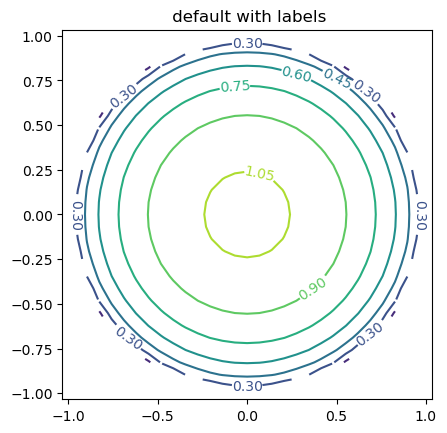

In [3]:
import matplotlib.pyplot as plt
from matplotlib import cm

r_v = np.sqrt(xv**2 + yv**2) 
Z = width(r_v,R=1,G=G,nu=nu) 

# Plot the surface
fig, ax = plt.subplots()
CS = ax.contour(xv, yv, Z)

ax.clabel(CS, inline=True, fontsize=10)
ax.set_title(' default with labels')
plt.gca().set_aspect('equal')

In [4]:
kernel = "3DR0-H"
elas_prop = np.array([2*G*(1+nu), nu])
eta=3.0
max_leaf_size = 64
eps_aca = 1.0e-3
h = BEMatrix(kernel, vertex_coor, conn, elas_prop, max_leaf_size, eta, eps_aca,n_openMP_threads=8)

NUM OF OMP THREADS in BigWham: 8
 Now setting things for kernel ... 3DR0-H with properties size 2
--------------------
Hierarchical representation creation ...
Cluster tree creation time for the source mesh :  0
Cluster tree creation time for the source mesh :  0
Time for binary cluster tree construction  0.000381
 binary cluster tree depth =4
 Number of blocks =178
 Number of full blocks =100
 Number of low rank blocks =78
Pattern Created 
Hierarchical representation complete.
--------------------
Populating Hierarchical matrix ...
 Loop on full blocks construction  
 N full blocks 100 
Loop on low rank blocks construction
N low rank blocks 78
dof_dimension: 3
Creation of hmat done in 0.857713
Compression ratio - 0.537228
Hmat object - built 
Hierarchical matrix construction complete.
Compression Ratio = 0.537228, eps_aca = 0.001, eta = 3
Hierarchical matrix  construction time = :  0.857741
--------------------


# Computing tractions from imposed width 

First we impose the solution of the fracture width (as function of radial distance). We ensure that the imposed width is zero for elements that are not within the radial fracture.

In [5]:
# compute real width
col_pts = h.getCollocationPoints()
rr_col_pts = np.sqrt(col_pts[:,0]**2+col_pts[:,1]**2)
width_c = np.nan_to_num(width(rr_col_pts,R=1,G=G,nu=nu))
true_dd =np.zeros(rr_col_pts.size*3)
true_dd[2::3]=width_c

/Users/bricelecampion/ClionProjects/BigWham-Tutorials/examples/3d/../../solutions/penny_shaped_crack_uniform.py:35: RuntimeWarning: invalid value encountered in sqrt
  return (4*sig*(1-nu)/(np.pi*G))*np.sqrt(R*R-r_corr*r_corr)


We compute the corresponding traction via the dot product of the BEM matrix with the vector of imposed displacemennt discontinuity as H.dd 

In [6]:
T = h.matvec(true_dd)

Text(0.5, 1.0, 'T_3(r)')

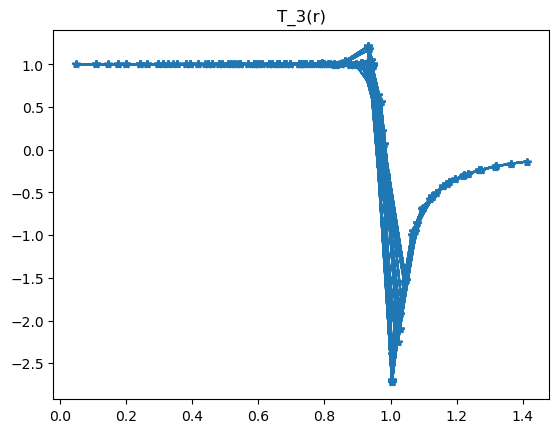

In [7]:

# Plot the normal traction imposed by such imposed dd 

plt.plot(rr_col_pts, T[2::3], "-*")
plt.title('T_3(r)')


In [8]:
# 
elt_in_crack=np.where(rr_col_pts<1.)[0]
# let's get the traction for element inside the crack - not the shear stractions should be near zero
T1=T[0::3]
T2=T[1::3]
T3=T[2::3]


We verify that the normal induced traction inside the crack is close to 1 (median, mean and variance of T3 for all square elements inside the crack):

In [9]:
(np.median(T3[elt_in_crack]),np.mean(T3[elt_in_crack]),np.var(T3[elt_in_crack]) )

(1.0008693070411503, 0.9246225624039092, 0.1412946951468976)

The shear component of the tractions must be zero everywhere for a planar crack (to check we sum up the absolute value of all shear traction along $e_1$ and $e_2$):

In [10]:
(np.sum(np.abs(T1)),np.sum(np.abs(T2)))

(0.0, 0.0)

Of course, because we model a circle with squares, the traction obtained near the fracture front are quite incorrect - but otherwise not bad inside the crack.

Text(0.5, 1.0, '$T_3$(r)')

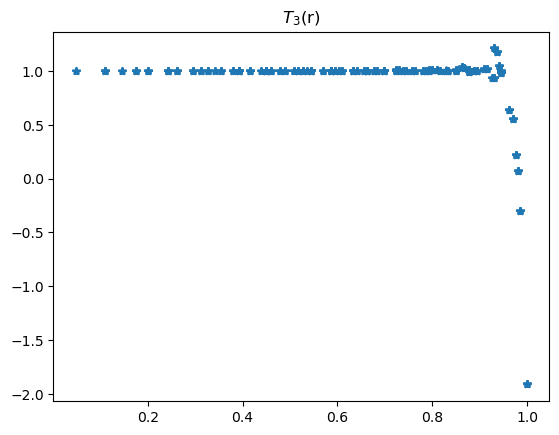

In [11]:
plt.plot(rr_col_pts[elt_in_crack], T3[elt_in_crack], "*")
plt.title('$T_3$(r)')

In [12]:
(np.mean(T1),np.mean(T2))

(0.0, 0.0)

# Imposing tractions and computing corresponding width

Here  we do not make any correction to the element that are 'cut' by the fracture front... We just imposed that the width of the element outside the crack remain zero, while the normal traction inside the crack is set to unity (uniform loading). To solve such a problem, we restrict the unknowns to be the displacement discontinuities of the element inside the fracture.

In [13]:
T_imposed=np.zeros([3*n_x*n_y])
T_imposed[2::3][elt_in_crack]=1.

from scipy.sparse.linalg import gmres
from scipy.sparse.linalg import LinearOperator

# here we solve for the displacement discontinuity for element within the fracture - imposing that the displacement are zeros for element outside the crack.
# so we  solve for the reduced system - for the mode 1 component only here. 
T_imp=elt_in_crack*0.+1.0
dd_all = np.zeros([3*n_x*n_y])

def reduce_to_crack_mv(x):
    #
    dd_all[2::3][elt_in_crack]=x
    f_all = h.matvec(dd_all)
    return f_all[2::3][elt_in_crack]

n_u =elt_in_crack.size
A = LinearOperator((n_u,n_u), matvec=reduce_to_crack_mv)

hdiag= h.H_diag() #
diag_r_3=hdiag[2::3][elt_in_crack]
from scipy.sparse import diags

M_jacobi=diags(1./diag_r_3, dtype=np.float_)

d3 = gmres(A,T_imp,M=M_jacobi,rtol=1e-4)[0]


As expected, we observe an error in the width in the square elements cut by the fracture front. But the fracture width is otherwise following well the analytical solution. Note that the solution can be improved in the near - tip region by using a correction on the self-effect (first proposed by Ryder & Napier (1985), see also Peirce & Detournay (2008), Gordeliy & Detournay (2011)). We do not investigate this correction here, note that such a correction is implemented in PyFrac for example. 

Text(0.5, 1.0, 'Fracture width w(r)')

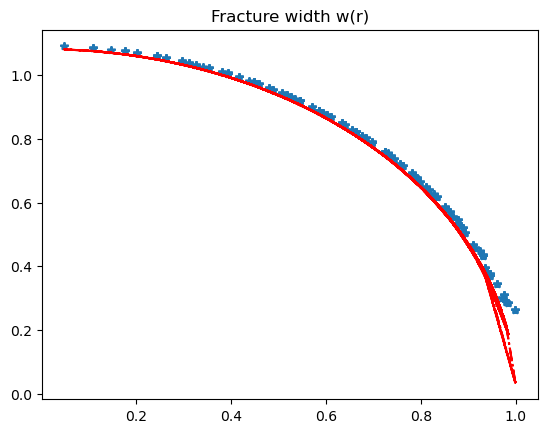

In [14]:
plt.plot(rr_col_pts[elt_in_crack], d3, "*")
plt.plot(rr_col_pts[elt_in_crack], width(rr_col_pts[elt_in_crack],G=G,nu=nu), "-.r")

plt.title('Fracture width w(r)')